In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from dm_control import mjcf
from typing import Tuple
from tqdm import trange
from pathlib import Path

from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs
from flygym.util.vision import visualize_visual_input

In [25]:
class FovCalibrationArena(BaseArena):
    def __init__(
        self,
        size: Tuple[float, float] = (50, 50),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
    ):
        self.root_element = mjcf.RootElement()
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.3, 0.3, 0.3),
            rgb2=(0.4, 0.4, 0.4),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(10, 10),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.friction = friction

        # Add camera
        # <camera name="camera_top_zoomout" class="nmf" mode="fixed"  ipd="0.068" pos="0 0 100" euler="0 0 0" fovy="20"/>
        self.root_element.worldbody.add(
            "camera",
            name="birdseye_cam",
            mode="fixed",
            pos=(0, 0, 150),
            euler=(0, 0, 0),
            fovy=20,
        )

        # Add FOV limit markers
        left_points = [(19.8324, -2.5837), (9.4646, 17.6188), (-13.6229, 14.6429)]
        colors = [
            # left eye: anterior up to red, posterior down to blue, green in the middle
            [(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)],
            # right eye: ant up to yellow, post down to cyan, magenta in the middle
            [(1, 1, 0, 1), (1, 0, 1, 1), (0, 1, 1, 1)],
        ]
        radius = 0.15
        height = 20
        for i in range(3):
            x, left_y = left_points[i]
            self.root_element.worldbody.add(
                "geom",
                type="cylinder",
                size=(radius, height),
                pos=(x, left_y, height / 2),
                rgba=colors[0][i],
            )
            self.root_element.worldbody.add(
                "geom",
                type="cylinder",
                size=(radius, height),
                pos=(x, -left_y, height / 2),
                rgba=colors[1][i],
            )

        # Marker every 10 degrees
        for i in range(60):
            x = np.sin(i * 2 * np.pi / 60) * 15
            y = np.cos(i * 2 * np.pi / 60) * 15
            rgba = (0, 0, 0, 0.5) if i % 3 == 0 else (1, 1, 1, 0.5)
            radius = 0.1
            height = 20
            self.root_element.worldbody.add(
                "geom",
                type="cylinder",
                size=(radius, height),
                pos=(x, y, height / 2),
                rgba=rgba,
            )

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

In [26]:
# Initialize simulation
run_time = 1
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.1,
    enable_vision=True,
    render_raw_vision=True,
    render_camera="birdseye_cam",
)
arena = FovCalibrationArena()
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    arena=arena,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

obs, reward, terminated, truncated, info = nmf.step({"joints": data_block[:, 0]})
for i in trange(100):
    joint_pos = data_block[:, 0]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

100%|██████████| 100/100 [00:00<00:00, 171.02it/s]


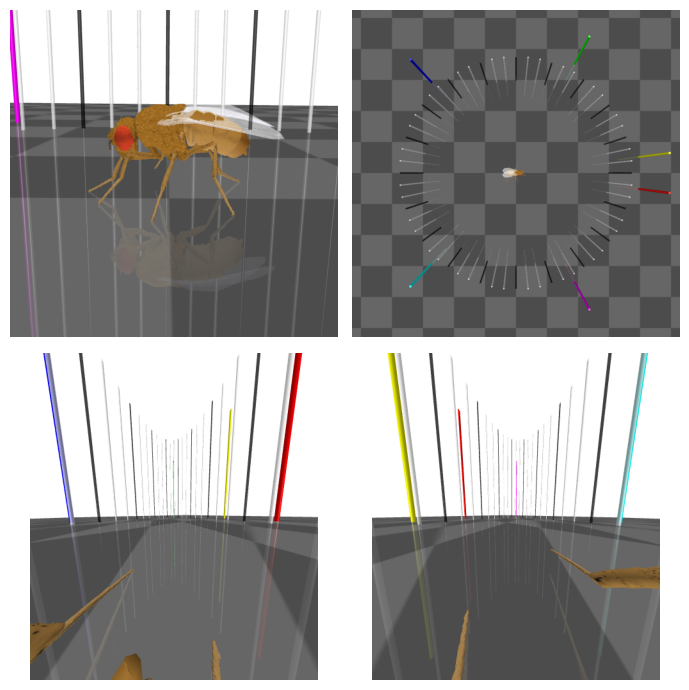

In [27]:
# Visualize static camera views upon initialization
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(nmf.physics.render(700, 700, camera_id="Animat/camera_left"))
axs[0, 0].axis("off")
axs[0, 1].imshow(nmf.physics.render(700, 700, camera_id="birdseye_cam"))
axs[0, 1].axis("off")
axs[1, 0].imshow(nmf.curr_raw_visual_input[0])
axs[1, 0].axis("off")
axs[1, 1].imshow(nmf.curr_raw_visual_input[1])
axs[1, 1].axis("off")
plt.tight_layout()
plt.show()
nmf.close()

In [28]:
raw_img = nmf.curr_raw_visual_input[0]

In [29]:
def get_fish_xn_yn(source_x, source_y, radius, distortion):
    """
    Get normalized x, y pixel coordinates from the original image and return normalized 
    x, y pixel coordinates in the destination fished image.
    :param distortion: Amount in which to move pixels from/to center.
    As distortion grows, pixels will be moved further from the center, and vice versa.
    """

    if 1 - distortion*(radius**2) == 0:
        print("!")
        return source_x, source_y

    return source_x / (1 - (distortion*(radius**2))), source_y / (1 - (distortion*(radius**2)))


def fish(img, distortion_coefficient, zoom):
    """
    :type img: numpy.ndarray
    :param distortion_coefficient: The amount of distortion to apply.
    :return: numpy.ndarray - the image with applied effect.
    """

    # If input image is only BW or RGB convert it to RGBA
    # So that output 'frame' can be transparent.
    w, h = img.shape[0], img.shape[1]

    # prepare array for dst image
    dstimg = np.zeros_like(img)

    # floats for calcultions
    w, h = float(w), float(h)

    # easier calcultion if we traverse x, y in dst image
    for x in range(len(dstimg)):
        for y in range(len(dstimg[x])):
            # normalize x and y to be in interval of [-1, 1]
            xnd, ynd = float((2*x - w)/w), float((2*y - h)/h)

            # zoom effect
            xnd /= zoom
            ynd /= zoom

            # get xn and yn distance from normalized center
            rd = np.sqrt(xnd**2 + ynd**2)

            # new normalized pixel coordinates
            xdu, ydu = get_fish_xn_yn(xnd, ynd, rd, distortion_coefficient)

            # convert the normalized distorted xdn and ydn back to image pixels
            xu, yu = int(((xdu + 1)*w)/2), int(((ydu + 1)*h)/2)

            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= xu and xu < img.shape[0] and 0 <= yu and yu < img.shape[1]:
                dstimg[x][y] = img[xu][yu]

    return dstimg.astype(np.uint8)

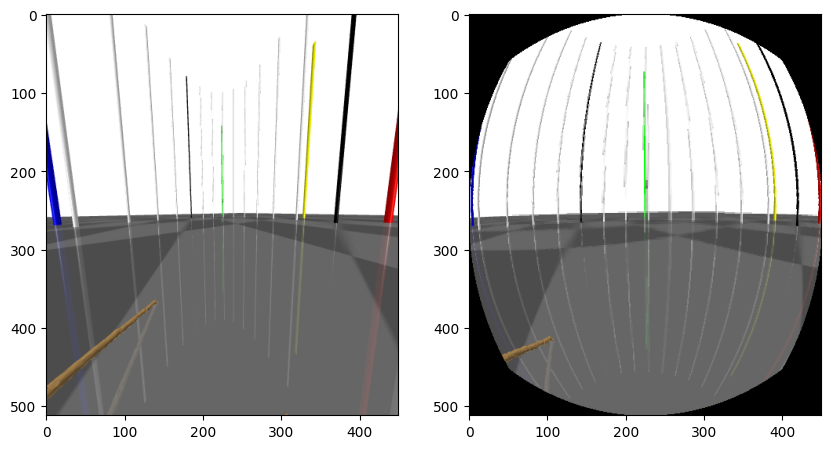

In [30]:
fish_img = fish(raw_img, 2.8, 2.25)
# fish_img = fish(np.zeros_like(raw_img), 2, 2)

fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(raw_img)
# axs[0].axis("off")
axs[1].imshow(fish_img)
# axs[1].axis("off")

In [73]:
%%timeit
fish_img = fish(raw_img, 2.8, 2.25)

445 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
def fish2(img, distortion_coefficient, zoom, nrows, ncols):
    # prepare array for dst image
    dstimg = np.zeros((nrows, ncols, 3), dtype="uint8")

    # easier calcultion if we traverse x, y in dst image
    for dst_row in range(nrows):
        for dst_col in range(ncols):
            # normalize x and y to be in interval of [-1, 1] and apply zoom
            dst_row_norm = float((2 * dst_row - nrows) / nrows) / zoom
            dst_col_norm = float((2 * dst_col - ncols) / ncols) / zoom

            # get xn and yn distance from normalized center
            dst_radius_norm = np.sqrt(dst_col_norm ** 2 + dst_row_norm ** 2)
            denom = 1 - (distortion_coefficient * (dst_radius_norm ** 2))+ 1e-6
            src_row_norm = dst_row_norm / denom
            src_col_norm = dst_col_norm / denom

            # convert the normalized distorted xdn and ydn back to image pixels
            src_row = int(((src_row_norm + 1) * nrows) / 2)
            src_col = int(((src_col_norm + 1) * ncols) / 2)

            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= src_row and src_row < nrows and 0 <= src_col and src_col < ncols:
                dstimg[dst_row][dst_col] = img[src_row][src_col]

    return dstimg

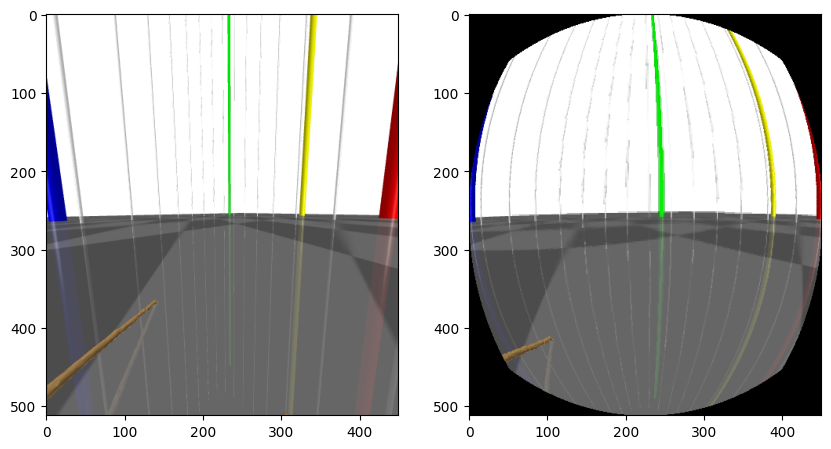

In [115]:
fish_img = fish2(raw_img, 2.8, 2.25, raw_img.shape[0], raw_img.shape[1])
# fish_img = fish(np.zeros_like(raw_img), 2, 2)

fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(raw_img)
# axs[0].axis("off")
axs[1].imshow(fish_img)
# axs[1].axis("off")

In [116]:
%%timeit
fish_img = fish2(raw_img, 2.8, 2.25, raw_img.shape[0], raw_img.shape[1])

352 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
import numba as nb

@nb.njit(parallel=True)
def fish2_jit(img, distortion_coefficient, zoom, nrows, ncols):
    """Based on https://github.com/Gil-Mor/iFish/tree/master"""
    
    # prepare array for dst image
    dst_img = np.zeros((nrows, ncols, 3), dtype="uint8")

    # easier calcultion if we traverse x, y in dst image
    for dst_row in nb.prange(nrows):
        for dst_col in nb.prange(ncols):
            # normalize x and y to be in interval of [-1, 1] and apply zoom
            dst_row_norm = float((2 * dst_row - nrows) / nrows) / zoom
            dst_col_norm = float((2 * dst_col - ncols) / ncols) / zoom

            # get xn and yn distance from normalized center
            dst_radius_norm = np.sqrt(dst_col_norm ** 2 + dst_row_norm ** 2)
            denom = 1 - (distortion_coefficient * (dst_radius_norm ** 2)) + 1e-6
            src_row_norm = dst_row_norm / denom
            src_col_norm = dst_col_norm / denom

            # convert the normalized distorted xdn and ydn back to image pixels
            src_row = int(((src_row_norm + 1) * nrows) / 2)
            src_col = int(((src_col_norm + 1) * ncols) / 2)

            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= src_row and src_row < nrows and 0 <= src_col and src_col < ncols:
                dst_img[dst_row][dst_col] = img[src_row][src_col]

    return dst_img

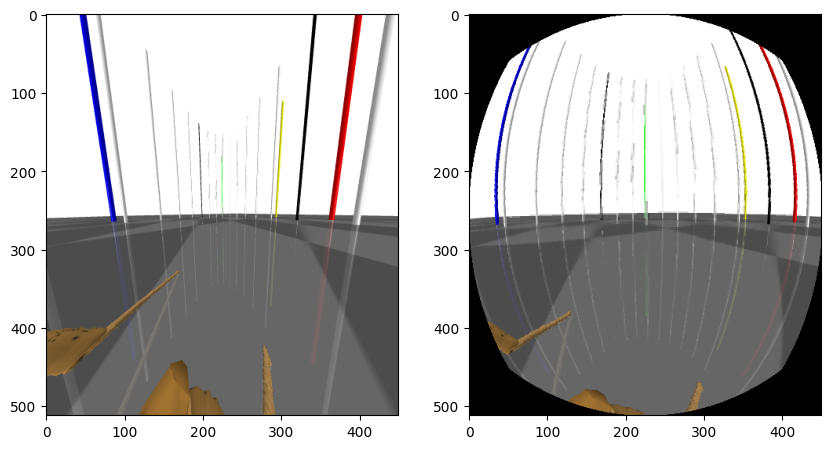

In [8]:
fish_img = fish2_jit(raw_img, 2.8, 2.25, raw_img.shape[0], raw_img.shape[1])
# fish_img = fish(np.zeros_like(raw_img), 2, 2)

fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(raw_img)
# axs[0].axis("off")
axs[1].imshow(fish_img)
# axs[1].axis("off")

In [13]:
%%timeit
fish_img = fish2_jit(raw_img, 2.8, 2.25, raw_img.shape[0], raw_img.shape[1])

687 µs ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


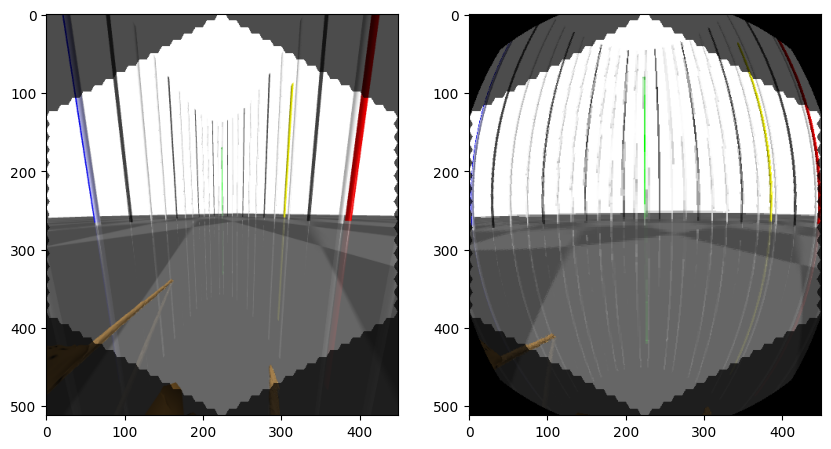

In [29]:
from flygym.util.vision import ommatidia_id_map
fish_img = fish2_jit(raw_img, 3.8, 2.72, raw_img.shape[0], raw_img.shape[1])

is_outside = ommatidia_id_map == 0

fish_img_masked = fish_img.copy()
fish_img_masked[is_outside] = fish_img_masked[is_outside] * 0.3

raw_img_masked = raw_img.copy()
raw_img_masked[is_outside] = raw_img_masked[is_outside] * 0.3

fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(raw_img_masked)
# axs[0].axis("off")
axs[1].imshow(fish_img_masked)
# axs[1].axis("off")